Для компании, занимающейся разрабатывает мобильных игр, нужна **функия для подсчета retention**.
Помимо этого, в компании провели **A/B тестирование** наборов акционных предложений. На основе имеющихся данных необходимо определить, какой набор можно считать лучшим.
Также, требуется предложить **набор метрик** для оценки результатов последнего прошедшего тематического события в игре.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date
import numpy as np
import plotly.express as px

import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp

%matplotlib inline

# Часть 1. Retantion

Данные для retention имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

reg_ts	uid <br>
906166566	2 <br>
906344325	2 <br>
906686169	2 <br>
906893386	2 <br>
906980227	2 <br>

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

auth_ts	uid <br>
906166566	2 <br>
924422172	3 <br>
937374732	4 <br>
947425117	5 <br>
955630339	6 <br>


### Загрузка данных и их исследование

In [4]:
# таблица с регистрациями
df_reg = pd.read_csv('/Users/daryastepanichsheva/Downloads/problem1-reg_data.csv', sep=';')
df_reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [5]:
# пропущенные значения
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [6]:
# дупликаты
df_reg.duplicated().sum()

0

In [7]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Пропущенных и повторяющихся значений нет. Нужно привести время в удобный формат

In [8]:
# приведение времени в нужный формат
df_reg['reg_time'] = df_reg.reg_ts.apply(lambda x: datetime.datetime.utcfromtimestamp(int(x)))

In [9]:
df_reg

,reg_ts,uid,reg_time
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27
3,959523541,4,2000-05-28 14:19:01
4,969103313,5,2000-09-16 11:21:53
...,...,...,...
999995,1600874034,1110618,2020-09-23 15:13:54
999996,1600874086,1110619,2020-09-23 15:14:46
999997,1600874139,1110620,2020-09-23 15:15:39
999998,1600874191,1110621,2020-09-23 15:16:31


In [10]:
# таблицас аутентификациями
df_au = pd.read_csv('/Users/daryastepanichsheva/Downloads/problem1-auth_data.csv', sep=';')
df_au

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [11]:
df_au.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [12]:
df_au.duplicated().sum()

0

In [13]:
# исследование
df_au.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Пропущенных и повторяющихся значений нет. Нужно привести время в удобный формат

In [14]:
# формат
df_au['au_time'] = df_au.auth_ts.apply(lambda x: datetime.datetime.utcfromtimestamp(int(x)))

In [15]:
df_au

,auth_ts,uid,au_time
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39
...,...,...,...
9601008,1600874034,1110618,2020-09-23 15:13:54
9601009,1600874086,1110619,2020-09-23 15:14:46
9601010,1600874139,1110620,2020-09-23 15:15:39
9601011,1600874191,1110621,2020-09-23 15:16:31


In [16]:
# объединение таблиц
df1 = pd.merge(df_reg, df_au, on='uid', how='outer')
df1

,reg_ts,uid,reg_time,auth_ts,au_time
0,911382223,1,1998-11-18 09:43:43,911382223,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09,932683089,1999-07-22 22:38:09
2,932683089,2,1999-07-22 22:38:09,932921206,1999-07-25 16:46:46
3,932683089,2,1999-07-22 22:38:09,933393015,1999-07-31 03:50:15
4,932683089,2,1999-07-22 22:38:09,933875379,1999-08-05 17:49:39
...,...,...,...,...,...
9601008,1600874034,1110618,2020-09-23 15:13:54,1600874034,2020-09-23 15:13:54
9601009,1600874086,1110619,2020-09-23 15:14:46,1600874086,2020-09-23 15:14:46
9601010,1600874139,1110620,2020-09-23 15:15:39,1600874139,2020-09-23 15:15:39
9601011,1600874191,1110621,2020-09-23 15:16:31,1600874191,2020-09-23 15:16:31


In [17]:
# оставляю нужные столбцы
df = df1[['uid', 'reg_time', 'au_time']].sort_values('au_time').query('reg_time >= "2020-01-01"')
df

,uid,reg_time,au_time
8358767,716362,2020-01-01 00:01:21,2020-01-01 00:01:21
8358768,716364,2020-01-01 00:02:42,2020-01-01 00:02:42
8358769,716365,2020-01-01 00:04:04,2020-01-01 00:04:04
8358770,716366,2020-01-01 00:05:25,2020-01-01 00:05:25
8358771,716367,2020-01-01 00:06:47,2020-01-01 00:06:47
...,...,...,...
9601008,1110618,2020-09-23 15:13:54,2020-09-23 15:13:54
9601009,1110619,2020-09-23 15:14:46,2020-09-23 15:14:46
9601010,1110620,2020-09-23 15:15:39,2020-09-23 15:15:39
9601011,1110621,2020-09-23 15:16:31,2020-09-23 15:16:31


# Retention по дням от регистрации


In [18]:
# достаю текущую дату
today = date.today()
today = today.strftime("%Y-%m-%d")
today

'2024-05-16'

In [19]:
def retention(data, date_from, date_to=today):
    """ data - данные для анализа 
        date_from - дата начала периода
        date_to - дата конца нужного периода (по умолчанию стоит текущая дата) """
    
    # фильтрация данных по нужному периоду
    df_ret = data.loc[(data['reg_time'] >= pd.to_datetime(date_from)) & (data['reg_time'] <= pd.to_datetime(date_to))]

    # создания колонок с когортами и датами активных дней 
    # (В качестве индексов будет использоваться дата авторизации, 
    # чтобы было проще отследить связь между событиями и активностью пользователей.)

    df_ret['cohort'] = df_ret['reg_time'].dt.to_period('D')
    df_ret['active_day'] = df_ret['au_time'].dt.to_period('D')

    # группировный и подсчет активных пользователей
    df_ret = df_ret.groupby(["cohort", "active_day"])[["uid"]].nunique()
    
    df_ret = df_ret.rename(columns={'uid': 'total_users'})
    
    # приведение к относительным числам
    df_ret['retention'] = df_ret.groupby('cohort').apply(lambda x: x / x.iloc[0])
    
    df_ret = df_ret.reset_index()
    
    # формирование 'косынки'
    ret = df_ret.pivot(index='cohort', columns='active_day', values='retention')
    ret = ret.dropna(how='all')
    
    # стиль
    ur_style = (ret
            .style
            .set_caption('User retention by cohort') 
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
    
    return ur_style

**Проверка функции с датой конца периода**

In [20]:
retention(df, "2020-09-01", "2020-09-15")

/var/folders/hk/wr8jw_ps61945y5lg0q6sw9h0000gn/T/ipykernel_95350/3421756377.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ret['cohort'] = df_ret['reg_time'].dt.to_period('D')
/var/folders/hk/wr8jw_ps61945y5lg0q6sw9h0000gn/T/ipykernel_95350/3421756377.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ret['active_day'] = df_ret['au_time'].dt.to_period('D')


active_day,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23
cohort,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01,100.00%,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%,4.35%,5.04%,4.16%,4.35%,3.59%,4.35%,1.58%
2020-09-02,,100.00%,2.52%,3.90%,4.66%,5.67%,6.23%,7.12%,6.30%,4.85%,4.09%,5.67%,5.48%,5.48%,4.35%,4.97%,5.29%,4.16%,4.85%,3.90%,3.72%,4.66%,2.64%
2020-09-03,,,100.00%,2.33%,5.41%,4.71%,6.54%,6.98%,8.55%,6.35%,5.47%,6.29%,6.35%,5.53%,5.85%,5.97%,5.47%,5.34%,4.40%,4.84%,4.65%,5.47%,2.39%
2020-09-04,,,,100.00%,2.01%,3.64%,3.64%,5.15%,6.40%,7.28%,4.96%,5.34%,4.33%,5.65%,5.52%,4.33%,5.59%,4.39%,4.52%,4.52%,4.27%,4.77%,2.64%
2020-09-05,,,,,100.00%,2.76%,3.95%,4.64%,5.45%,5.89%,7.46%,4.89%,5.08%,5.45%,6.02%,5.20%,4.57%,5.39%,4.51%,5.14%,4.45%,4.76%,2.51%
2020-09-06,,,,,,100.00%,3.13%,4.32%,5.44%,5.63%,5.88%,6.82%,6.07%,5.82%,5.50%,4.88%,4.75%,5.38%,5.19%,5.50%,4.57%,4.82%,2.56%
2020-09-07,,,,,,,100.00%,2.94%,4.25%,5.37%,5.06%,6.37%,7.31%,5.25%,4.12%,5.62%,6.00%,5.68%,4.56%,5.06%,4.25%,5.06%,3.37%
2020-09-08,,,,,,,,100.00%,1.75%,3.93%,3.93%,4.86%,7.61%,7.54%,6.61%,5.17%,5.17%,6.55%,5.36%,5.92%,5.17%,4.74%,3.05%
2020-09-09,,,,,,,,,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%


**Проверка функции с датой по умолчанию**

In [21]:
retention(df, "2020-09-01")

/var/folders/hk/wr8jw_ps61945y5lg0q6sw9h0000gn/T/ipykernel_95350/3421756377.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ret['cohort'] = df_ret['reg_time'].dt.to_period('D')
/var/folders/hk/wr8jw_ps61945y5lg0q6sw9h0000gn/T/ipykernel_95350/3421756377.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ret['active_day'] = df_ret['au_time'].dt.to_period('D')


active_day,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23
cohort,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01,100.00%,2.02%,4.10%,4.22%,4.60%,6.43%,5.61%,6.43%,4.10%,5.42%,5.11%,5.36%,4.85%,5.49%,4.29%,4.41%,4.35%,5.04%,4.16%,4.35%,3.59%,4.35%,1.58%
2020-09-02,,100.00%,2.52%,3.90%,4.66%,5.67%,6.23%,7.12%,6.30%,4.85%,4.09%,5.67%,5.48%,5.48%,4.35%,4.97%,5.29%,4.16%,4.85%,3.90%,3.72%,4.66%,2.64%
2020-09-03,,,100.00%,2.33%,5.41%,4.71%,6.54%,6.98%,8.55%,6.35%,5.47%,6.29%,6.35%,5.53%,5.85%,5.97%,5.47%,5.34%,4.40%,4.84%,4.65%,5.47%,2.39%
2020-09-04,,,,100.00%,2.01%,3.64%,3.64%,5.15%,6.40%,7.28%,4.96%,5.34%,4.33%,5.65%,5.52%,4.33%,5.59%,4.39%,4.52%,4.52%,4.27%,4.77%,2.64%
2020-09-05,,,,,100.00%,2.76%,3.95%,4.64%,5.45%,5.89%,7.46%,4.89%,5.08%,5.45%,6.02%,5.20%,4.57%,5.39%,4.51%,5.14%,4.45%,4.76%,2.51%
2020-09-06,,,,,,100.00%,3.13%,4.32%,5.44%,5.63%,5.88%,6.82%,6.07%,5.82%,5.50%,4.88%,4.75%,5.38%,5.19%,5.50%,4.57%,4.82%,2.56%
2020-09-07,,,,,,,100.00%,2.94%,4.25%,5.37%,5.06%,6.37%,7.31%,5.25%,4.12%,5.62%,6.00%,5.68%,4.56%,5.06%,4.25%,5.06%,3.37%
2020-09-08,,,,,,,,100.00%,1.75%,3.93%,3.93%,4.86%,7.61%,7.54%,6.61%,5.17%,5.17%,6.55%,5.36%,5.92%,5.17%,4.74%,3.05%
2020-09-09,,,,,,,,,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%


Функция работает корректно


#  Часть 2. А/Б тест

В ходе A/B теста двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Формат данных:

user_id	revenue	testgroup  
1	0	b  
2	0	a  
3	0	a  
4	0	b  
5	0	b  

In [22]:
# таблица с данными АБ-теста
ab = pd.read_csv('/Users/daryastepanichsheva/Downloads/Проект_1_Задание_2.csv', sep=';')
ab

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [23]:
# исслдеование данных
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [24]:
ab.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [25]:
ab.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [26]:
ab.duplicated().sum()

0

Данные в порядке. Пропущенных значений и дупликатов нет.

## А/Б-тесты

In [27]:
# проверка количества значений в каждой группе 
ab.groupby('testgroup').count()

,user_id,revenue
testgroup,,
a,202103,202103
b,202667,202667


Сильного перекоса в размерах групп нет.

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

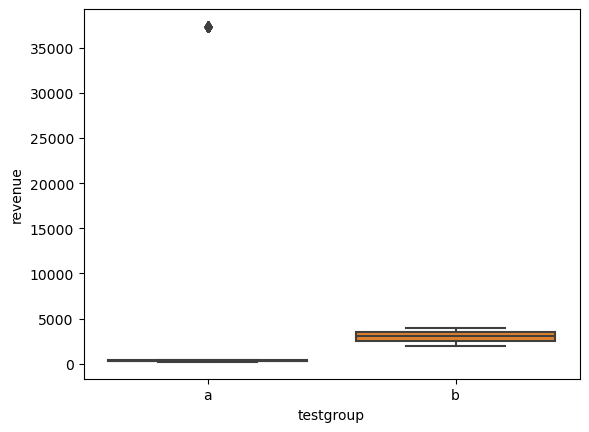

In [28]:
# построим боксплот
sns.boxplot(ab.query('revenue > 0'), x='testgroup', y='revenue')

В контрольной группе видно наличие выброса. 

Перед тестами визиализирую распределение данных

''

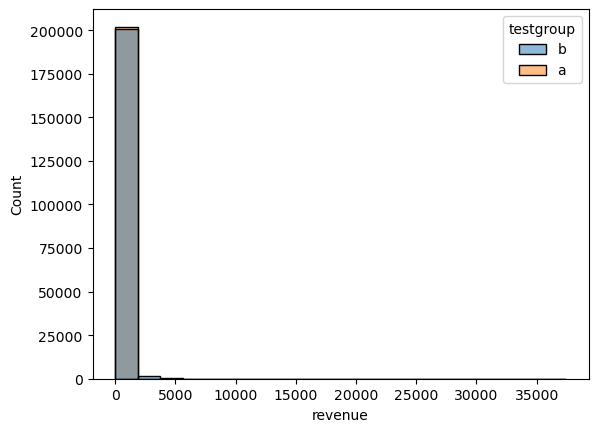

In [29]:
# все значения
sns.histplot(data=ab, 
             x='revenue', 
             hue='testgroup')
;

''

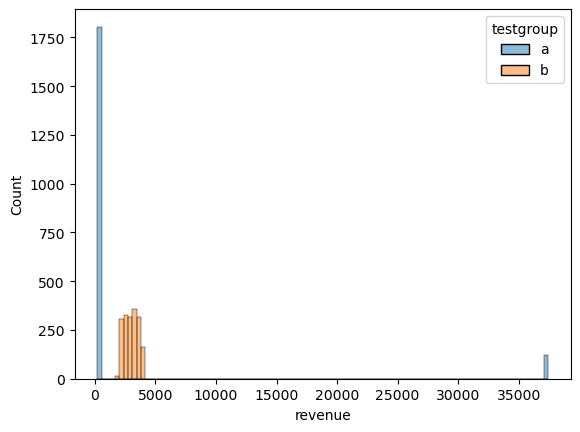

In [30]:
# ненулевые значения
sns.histplot(data=ab.query('revenue > 0'), 
             x='revenue', 
             hue='testgroup')
;

''

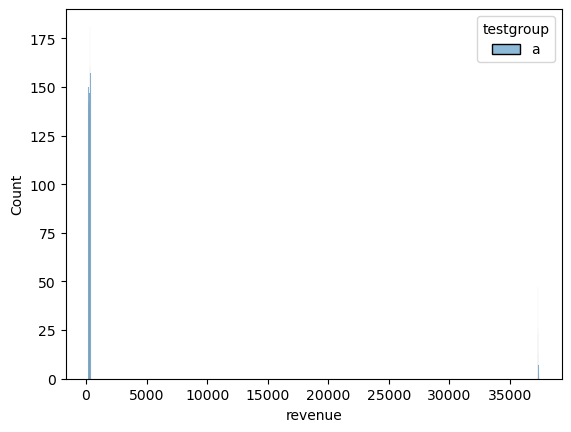

In [31]:
# ненулевые значения в группе А
sns.histplot(data=ab.query('revenue > 0 & testgroup == "a"'), 
             x='revenue', 
             hue='testgroup')
;

''

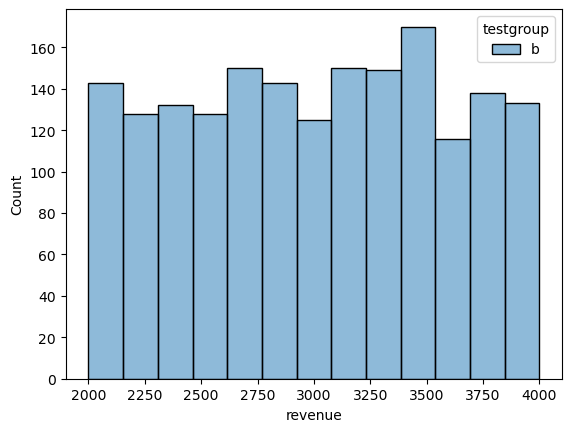

In [32]:
# ненулевые значения в группе В
sns.histplot(data=ab.query('revenue > 0 & testgroup == "b"'), 
             x='revenue', 
             hue='testgroup')
;

Из графиков видно, что данные в обеих группах не распределены нормально. Проверять нормальность распределения тестом в данном случае не имеет особого смысла. Достаточно большая выборка позволяет нам использовать t-test.

Буду применять t-тест Уэлча (т.к. у него нет недостатков по сравнению с t-тестом Стьюдента, я так же решила не проверять тестом гомогенность дисперсий)  

In [33]:
# ARPU
ab.groupby('testgroup', as_index=False).agg({'revenue': 'mean'}) 

,testgroup,revenue
0,a,25.413720
1,b,26.751287


- $H_0$: средние значения выборок НЕ различаются
- $H_1$: средние значения выборок различаются

In [37]:
# выполняем t-тест
t_statistic, p_value = ss.ttest_ind(ab.query('testgroup == "a"').revenue,
                                    ab.query('testgroup == "b"').revenue,
                                    equal_var=False)

# выводим результаты
print("Значение t-статистики:", t_statistic)
print("Значение p-value:", p_value)

# проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средние значения выборок различаются")
else:
    print("Принимаем нулевую гипотезу: средние значения выборок не различаются")


Значение t-статистики: -0.6234876562792212
Значение p-value: 0.5329647014130866
Принимаем нулевую гипотезу: средние значения выборок не различаются


**Значимых различий в ARPU с пользователя не обнаружено.**

In [38]:
# количество платащих пользователей
ab.query('revenue > 0').groupby('testgroup', as_index=False).agg({'user_id': 'nunique'})

,testgroup,user_id
0,a,1928
1,b,1805


In [39]:
# новая колонка, где платящие и неплатящий пользователи представлены как 1 и 0 соответственно
ab['pay'] = ab.revenue.apply(lambda x: 1 if x > 0 else 0)

In [40]:
ab

,user_id,revenue,testgroup,pay
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [41]:
for_arppu = ab.query('pay == 1')
for_arppu

,user_id,revenue,testgroup,pay
72,73,351,a,1
160,161,3797,b,1
341,342,290,a,1
377,378,3768,b,1
385,386,250,a,1
...,...,...,...,...
404315,404316,262,a,1
404525,404526,3120,b,1
404543,404544,369,a,1
404602,404603,251,a,1


In [42]:
# ARPPU
for_arppu.groupby('testgroup', as_index=False).agg({'revenue': 'mean'})

,testgroup,revenue
0,a,2663.998444
1,b,3003.658172


- $H_0$: средние значения выборок НЕ различаются
- $H_1$: средние значения выборок различаются

In [43]:
# выполняем t-тест
t_statistic, p_value = ss.ttest_ind(for_arppu.query('testgroup == "a"').revenue,
                                    for_arppu.query('testgroup == "b"').revenue,
                                    equal_var=False)

# выводим результаты
print("Значение t-статистики:", t_statistic)
print("Значение p-value:", p_value)

# проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средние значения выборок различаются")
else:
    print("Принимаем нулевую гипотезу: средние значения выборок не различаются")

Значение t-статистики: -1.644630266430084
Значение p-value: 0.10020780398916015
Принимаем нулевую гипотезу: средние значения выборок не различаются


In [44]:
# CR
for_cr = pd.crosstab(ab.testgroup, ab.pay).reset_index()
for_cr

pay,testgroup,0,1
0,a,200175,1928
1,b,200862,1805


In [45]:
for_cr['CR'] = for_cr[1] / for_cr[0] * 100
for_cr

pay,testgroup,0,1,CR
0,a,200175,1928,0.963157
1,b,200862,1805,0.898627


Conversion rate в контрольной группе больше, чем в тестовой.

 Проверяем, значимы ли эти различия.

- Н0: доля платящих пользователей не отличается в зависимости от группы
- Н1: отличается в зависимости от группы

Применяем Хи-квадрат.

In [46]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(ab.testgroup, ab.pay))
stat, p

(4.374729521260405, 0.03647561892312613)

In [47]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**В группах есть значимые различия в доле платящих пользователей.**

**Выводы:**

Результаты анализа показали, что изменения не влияют на увеличения прибыли: ни ARPU, ни ARPPU не показали значимых отличий. В контрольной группе выше CR -  доля платящих пользователей значимо больше.

На данном этапе принимать изменения не рекомендуется.

Учитывая выбросы в конктольной группе, можно предположить, что было неверно проведено сплитование. Стоит рассмотреть вариант пересбора групп и повторное проведение тестов. 

# Часть 3. Метрики

**В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?**

**Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?**


Основные метрики **продукта** для оценки события:

**ARPU** -  средний доход на участника события.  
**DAU и MAU**  -  активные пользователи за день и за месяц  
**Retention rate** по дням среди участников  
Смотреть метрики по месяцам, чтобы оценивать, какие события более прибыльны, а также по отношению пользователям, не участвующим в событии.  


Кроме них, будут полезны:   
**средний чек**     
**кол-во новых, постоянных и вернувшихся пользователей**   


Далее, чтобы понимать, насколько пользователям интересны события, используем метрики **роста**:

оценка увлеченности:  
**продолжительность сессий**  
**кол-во сессий**  
**кол-во приглашений друзей**, если есть такая функция

оценка сложности уровней:  
**время прохождения уровней**  
**кол-во потраченных попыток**   
**кол-во пользователей, которые доходят до конца**   


В случае с откатами на несколько уровней назад я бы сказала, что это несколько рискованно: предположительно, игроки будут больше платить за дополнительные жизни или инструменты, чтобы избежать откатов, но может быть и такое, что из-за раздражения они перестанут участвовать или играть в принципе. Поэтому, возможно, имеет смысл *дополнительно* следить за следующими метриками:  
**churn rate**  
**размер перерывов между сессиями**  
**оценка удовлетворенности клиентов (customer satisfaction score, CSAT)**  
**оценки и отзывов приложения в магазинах**
